In [1]:
import cv2
import mediapipe as mp
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [3]:
dataset_path = 'D:\\Project\\eyeGazeTrackingSystem\\EyeGazeTracking\\dataset'
label_map = {
    'top-left': 1, 'top-center': 2, 'top-right': 3,
    'middle-left': 4, 'center': 5, 'middle-right': 6,
    'bottom-left': 7, 'bottom-center': 8, 'bottom-right': 9
}

In [5]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

LEFT_EYE_INDICES = [33, 133]
RIGHT_EYE_INDICES = [362, 263]

In [7]:
def get_eye_crop(image, landmarks, indices):
    h, w = image.shape[:2]
    pts = np.array([[int(landmarks[i].x * w), int(landmarks[i].y * h)] for i in indices])
    cx, cy = np.mean(pts, axis=0).astype(int)
    x1, y1 = cx - 100, cy - 75
    x2, y2 = cx + 100, cy + 75
    return image[y1:y2, x1:x2]
def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0].landmark
    left_eye = get_eye_crop(image, landmarks, LEFT_EYE_INDICES)
    right_eye = get_eye_crop(image, landmarks, RIGHT_EYE_INDICES)


    combined = np.hstack((left_eye, right_eye))
    return combined

In [37]:
path = 'dataset'
arr = {}
for label in os.listdir(path):
    label_path = os.path.join(path,label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path,img_name)
        processed = process_image(image_path)
        if processed is not None:
            X.append(processed)
            y.append(label_map[label])

X = np.array(X)
y = np.array(y)

In [35]:
X = []
y = []

for folder_name, label in label_map.items():
    folder_path = os.path.join(dataset_path, folder_name)
    print(folder_path)
    for file_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder_name}"):
        image_path = os.path.join(folder_path, file_name)
        # print(image_path)
        processed = process_image(image_path)
        if processed is not None:
            X.append(processed)
            y.append(label_map[folder_name])

X = np.array(X)
y = np.array(y)

D:\Project\eyeGazeTrackingSystem\EyeGazeTracking\dataset\top-left


Processing top-left: 100%|████████████████████████████████████████████| 98/98 [00:07<00:00, 12.43it/s]


D:\Project\eyeGazeTrackingSystem\EyeGazeTracking\dataset\top-center


Processing top-center:  14%|█████▋                                    | 13/95 [00:01<00:06, 11.85it/s]


KeyboardInterrupt: 

In [17]:
print("Dataset created:")
print("X shape:", X.shape)  
print("y shape:", y.shape)  

Dataset created:
X shape: (2343, 150, 400, 3)
y shape: (2343,)


In [33]:
unique_values = np.unique(y).tolist()
unique_values

['1',
 '2',
 'bottom-center',
 'bottom-left',
 'bottom-right',
 'center',
 'middle-left',
 'middle-right',
 'top-center',
 'top-left',
 'top-right']

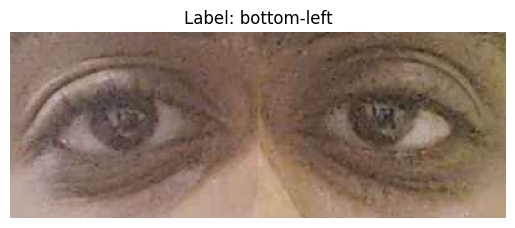

In [19]:
import matplotlib.pyplot as plt
import random

# Choose a random index
idx = random.randint(0, len(X) - 1)

# Show the image
plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
plt.title(f"Label: {y[idx]}")
plt.axis('off')
plt.show()

In [21]:
X = np.array(X, dtype=np.float32) / 255.0  # Normalize
y = np.array(y)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=9)


IndexError: index 9 is out of bounds for axis 1 with size 9

In [99]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(9, activation='softmax')
])

# 5. Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# 7. Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

C:\Users\LAKSHYA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 520ms/step - accuracy: 0.1207 - loss: 2.1972 - val_accuracy: 0.1324 - val_loss: 2.1954
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - accuracy: 0.1133 - loss: 2.1963 - val_accuracy: 0.1471 - val_loss: 2.1926
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step - accuracy: 0.1485 - loss: 2.1942 - val_accuracy: 0.1324 - val_loss: 2.1901
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.1275 - loss: 2.1886 - val_accuracy: 0.1471 - val_loss: 2.1887
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.1222 - loss: 2.1969 - val_accuracy: 0.1471 - val_loss: 2.1887
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 0.1210 - loss: 2.1837 - val_accuracy: 0.1471 - val_loss: 2.1884
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - accuracy: 0.1512 - loss: 2.1889 - val_accuracy: 0.1471 - val_loss: 2.1885
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 513ms/step - accuracy: 0.1499 - loss: 2.1869 - val_accuracy: 0

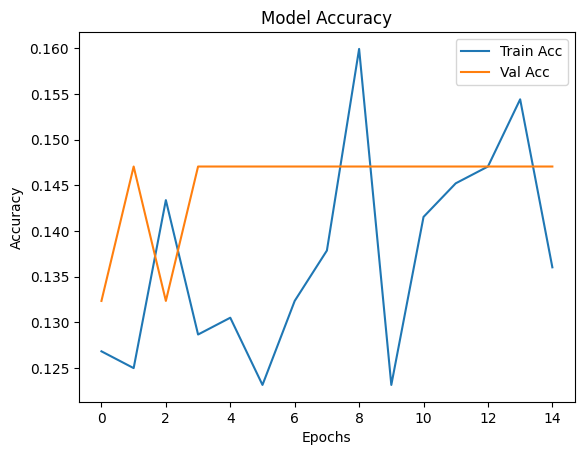

In [101]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [107]:
import os
import cv2
import numpy as np

folder_to_label = {
    'top-left': 1,
    'top-center': 2,
    'top-right': 3,
    'middle-left': 4,
    'center': 5,
    'middle-right': 6,
    'bottom-left': 7,
    'bottom-center': 8,
    'bottom-right': 9
}

data_dir = 'dataset'  # path to your dataset
image_paths = []
labels = []

for folder_name, label in folder_to_label.items():
    folder_path = os.path.join(data_dir, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)


In [109]:
features = []
final_labels = []

for img_path, label in zip(image_paths, labels):
    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.resize(img, (300, 300))  # resize for consistency if needed
    ratio = calculate_white_ratio(img)
    
    if ratio:
        features.append(ratio)
        final_labels.append(label)

X = np.array(features)
y = np.array(final_labels)


In [115]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np

# Set up models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP Neural Network": MLPClassifier(max_iter=1000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis()
}

# Prepare K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results
results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    results.append({
        'Model': name,
        'Mean Accuracy': np.mean(scores),
        'Std Dev': np.std(scores)
    })

# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
print(results_df)

C:\Users\LAKSHYA\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\LAKSHYA\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\LAKSHYA\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\LAKSHYA\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

                          Model  Mean Accuracy   Std Dev
0                 Random Forest       0.311314  0.028576
1             Gradient Boosting       0.308340  0.020301
2                 Decision Tree       0.300998  0.024642
3           K-Nearest Neighbors       0.280378  0.046604
4                      AdaBoost       0.239416  0.029308
5  Linear Discriminant Analysis       0.227651  0.046458
6                   Naive Bayes       0.223250  0.035553
7              SVM (RBF Kernel)       0.211464  0.016494
8            MLP Neural Network       0.186453  0.033488
9           Logistic Regression       0.127716  0.046517


C:\Users\LAKSHYA\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [133]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np

def apply_filters(img):
    filters = {}
    filters['original'] = img
    filters['gaussian'] = cv2.GaussianBlur(img, (5, 5), 0)
    filters['sobel'] = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=3)
    filters['laplacian'] = cv2.Laplacian(img, cv2.CV_64F)
    
    # Convert image to uint8 if needed
    if img.dtype != np.uint8:
        img_uint8 = cv2.convertScaleAbs(img)
    else:
        img_uint8 = img
    
    filters['median'] = cv2.medianBlur(img_uint8, 5)
    
    return filters


def build_cnn_model(input_shape, model_type='basic'):
    model = models.Sequential()
    if model_type == 'basic':
        model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(64, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    elif model_type == 'deep':
        model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        model.add(layers.Conv2D(64, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(128, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    elif model_type == 'dropout':
        model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(64, (3,3), activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [149]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

kf = KFold(n_splits=5, shuffle=True, random_state=42)
input_shape = (100, 200, 1)

cnn_models = ['basic', 'deep', 'dropout']
filter_types = ['original', 'gaussian', 'sobel', 'laplacian']

results = []

for filter_name in filter_types:
    # Apply filter to all images
    X_filtered = np.array([apply_filters(img)[filter_name] for img in X])
    X_filtered = X_filtered.astype('float32') / 255.0
    X_filtered = []

    for img_left, img_right in X:
        combined = np.concatenate([img_left, img_right], axis=1)
        
        X_filtered.append(combined)
    
    X_filtered = np.array(X_filtered)
    X_filtered = X_filtered.reshape(-1, 100, 200, 1).astype('float32') / 255.0


    for model_type in cnn_models:
        acc_scores = []
        for train_index, test_index in kf.split(X_filtered):
            model = build_cnn_model(input_shape, model_type)
            X_train, X_test = X_filtered[train_index], X_filtered[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train, epochs=5, verbose=0, batch_size=32)
            _, acc = model.evaluate(X_test, y_test, verbose=0)
            acc_scores.append(acc)
        results.append({
            'Filter': filter_name,
            'Model': model_type,
            'Mean Accuracy': np.mean(acc_scores),
            'Std Dev': np.std(acc_scores)
        })


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:

import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
print(df)
